Diabetic Retinopathy Classifier

In [6]:
# Input and setup
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight 

In [7]:
# === 1. Load and Visualize Class Distribution ===
df = pd.read_csv(r"C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\data\train.csv")
class_counts = df['diagnosis'].value_counts().sort_index()

print('Class Distribution:\n', class_counts)

Class Distribution:
 diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64


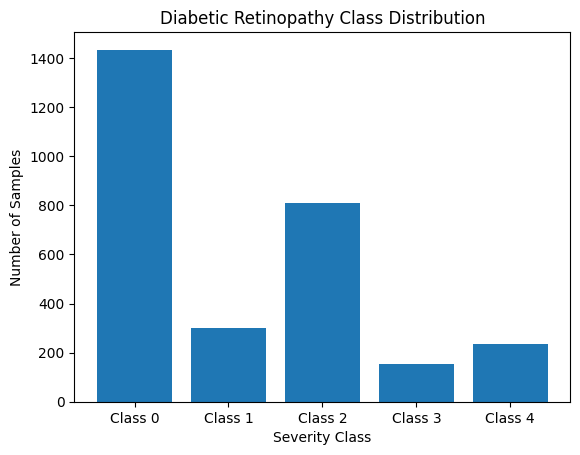

In [3]:
plt.bar(class_counts.index, class_counts.values, tick_label=[f"Class {i}" for i in class_counts.index])
plt.title("Diabetic Retinopathy Class Distribution")
plt.xlabel("Severity Class")
plt.ylabel("Number of Samples")
plt.savefig("../visuals/class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
#Missing or Corrupted Entries
#Check for missing values, duplicates, and stray formatting.
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check for duplicate IDs
duplicates = df[df['id_code'].duplicated()]
print("Duplicate entries:\n", duplicates)

# Check for stray spaces or formatting issues
df['id_code'] = df['id_code'].str.strip()
print("Unique diagnosis values:", df['diagnosis'].unique())

Missing values:
 id_code      0
diagnosis    0
dtype: int64
Duplicate entries:
 Empty DataFrame
Columns: [id_code, diagnosis]
Index: []
Unique diagnosis values: [2 1 4 0 3]


In [8]:
# === 2. Train/Validation Split ===
X = df['id_code']
y = df['diagnosis']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_df = pd.DataFrame({'id_code': X_train, 'diagnosis': y_train})
val_df = pd.DataFrame({'id_code': X_val, 'diagnosis': y_val})

In [5]:
# === 3. Compute Class Weights ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [6]:
# === 4. Define Transforms ===
minority_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

majority_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

transform_dict = {
    0: majority_transform,
    1: minority_transform,
    2: majority_transform,
    3: minority_transform,
    4: minority_transform
}


In [7]:
# === 5. Custom Dataset ===
class DRDataset(Dataset):
    def __init__(self, df, root_dir, transform_dict):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform_dict = transform_dict

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id_code']
        label = self.df.loc[idx, 'diagnosis']
        img_path = os.path.join(self.root_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')
        transform = self.transform_dict.get(label, transforms.ToTensor())
        image = transform(image)
        return image, label


In [8]:
# === 6. DataLoaders ===
train_dataset = DRDataset(train_df, root_dir='../data/train_images', transform_dict=transform_dict)
val_dataset = DRDataset(val_df, root_dir='../data/train_images', transform_dict=transform_dict)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [9]:
# === 7. Model Definition ===
class DRClassifier(nn.Module):
    def __init__(self):
        super(DRClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Output: (batch_size, 64, 1, 1)
            nn.Flatten(),                  # Output: (batch_size, 64)
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 5)
     )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [10]:
# === 8. Training Loop ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DRClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1: 100%|██████████| 74/74 [07:45<00:00,  6.29s/it]


Epoch 1, Loss: 119.1873


Epoch 2: 100%|██████████| 74/74 [07:06<00:00,  5.77s/it]


Epoch 2, Loss: 118.6789


Epoch 3: 100%|██████████| 74/74 [07:12<00:00,  5.85s/it]


Epoch 3, Loss: 116.4245


Epoch 4: 100%|██████████| 74/74 [07:20<00:00,  5.95s/it]


Epoch 4, Loss: 112.5843


Epoch 5: 100%|██████████| 74/74 [07:01<00:00,  5.70s/it]


Epoch 5, Loss: 110.3583


Epoch 6: 100%|██████████| 74/74 [06:40<00:00,  5.41s/it]


Epoch 6, Loss: 108.6836


Epoch 7: 100%|██████████| 74/74 [07:01<00:00,  5.70s/it]


Epoch 7, Loss: 105.9702


Epoch 8: 100%|██████████| 74/74 [06:56<00:00,  5.63s/it]


Epoch 8, Loss: 101.9503


Epoch 9: 100%|██████████| 74/74 [06:56<00:00,  5.63s/it]


Epoch 9, Loss: 99.6086


Epoch 10: 100%|██████████| 74/74 [07:00<00:00,  5.69s/it]

Epoch 10, Loss: 96.0800


In [11]:
# === 9. Validation accuracy and confusion matrix===
from sklearn.metrics import accuracy_score, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
print(f"Validation Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)

Validation Accuracy: 0.5836
Confusion Matrix:
 [[201  50  11  23   2]
 [  0  47   5   8   0]
 [  4  58  86  13   0]
 [  0  19   4   8   0]
 [  2  28   5  12   0]]


In [12]:
# === 10. Save Best Model ===
best_val_loss = float('inf')

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # === Validation Pass ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}")

    # === Save Best Model ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved best model")


Epoch 1:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 74/74 [06:54<00:00,  5.60s/it]


Epoch 1, Train Loss: 94.2270, Val Loss: 22.1356
✅ Saved best model


Epoch 2: 100%|██████████| 74/74 [07:14<00:00,  5.87s/it]


Epoch 2, Train Loss: 90.0477, Val Loss: 21.9548
✅ Saved best model


Epoch 3: 100%|██████████| 74/74 [07:13<00:00,  5.85s/it]


Epoch 3, Train Loss: 88.9504, Val Loss: 21.0224
✅ Saved best model


Epoch 4: 100%|██████████| 74/74 [06:47<00:00,  5.50s/it]


Epoch 4, Train Loss: 85.7209, Val Loss: 19.6324
✅ Saved best model


Epoch 5: 100%|██████████| 74/74 [09:05<00:00,  7.37s/it]


Epoch 5, Train Loss: 83.6556, Val Loss: 19.1881
✅ Saved best model


Epoch 6: 100%|██████████| 74/74 [09:36<00:00,  7.80s/it]


Epoch 6, Train Loss: 82.6020, Val Loss: 18.7077
✅ Saved best model


Epoch 7: 100%|██████████| 74/74 [09:20<00:00,  7.57s/it]


Epoch 7, Train Loss: 79.1931, Val Loss: 19.0593


Epoch 8: 100%|██████████| 74/74 [09:39<00:00,  7.83s/it]


Epoch 8, Train Loss: 80.4495, Val Loss: 18.5941
✅ Saved best model


Epoch 9: 100%|██████████| 74/74 [09:28<00:00,  7.68s/it]


Epoch 9, Train Loss: 76.6198, Val Loss: 18.3162
✅ Saved best model


Epoch 10: 100%|██████████| 74/74 [09:37<00:00,  7.80s/it]


Epoch 10, Train Loss: 76.5364, Val Loss: 17.8699
✅ Saved best model


In [13]:
# === 11. Additional Metrics: F1-score, Cohen’s Kappa, ROC–AUC ===
model.eval()
all_preds = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # shape: [batch_size, 5]
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())  # store raw logits

from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score

# After collecting all_preds and all_labels
f1 = f1_score(all_labels, all_preds, average='weighted')
kappa = cohen_kappa_score(all_labels, all_preds)

# For ROC–AUC, you need probabilities and one-hot labels
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(all_labels, classes=[0,1,2,3,4])
all_outputs_np = np.array(all_outputs)  # Convert list of arrays to single ndarray
y_pred_prob = torch.softmax(torch.from_numpy(all_outputs_np), dim=1).numpy()

roc_auc = roc_auc_score(y_true_bin, y_pred_prob, average='macro', multi_class='ovr')

print(f"F1-score: {f1:.4f}")
print(f"Cohen’s Kappa: {kappa:.4f}")
print(f"ROC–AUC: {roc_auc:.4f}")

F1-score: 0.7715
Cohen’s Kappa: 0.6479
ROC–AUC: 0.9220


In [2]:
# === 12. Model Explainability with Grad-CAM ===
import torch
import torch.nn as nn
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os

In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define Model ===
class DRClassifier(nn.Module):
    def __init__(self):
        super(DRClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# Initialize model and Grad-CAM
model = DRClassifier().to(device)
cam_extractor = GradCAM(model, target_layer=model.conv[3])  # second Conv2d layer

# === Define Grad-CAM Generator Function ===
def generate_gradcam(
    model, cam_extractor, val_df, base_img_dir, output_dir="visuals", 
    transform=None, device="cpu", num_samples=5
):
    os.makedirs(output_dir, exist_ok=True)
    
    if transform is None:
        transform = Compose([Resize((128, 128)), ToTensor()])
    
    model.eval()
    
    for i in range(num_samples):
        sample_id = val_df.iloc[i]['id_code']
        sample_path = os.path.join(base_img_dir, f"{sample_id}.png")
        
        if not os.path.exists(sample_path):
            print(f"❌ Missing image: {sample_path}")
            continue
        
        image = Image.open(sample_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        
        activation_map = cam_extractor(pred_class, output)
        original = to_pil_image(input_tensor.squeeze().cpu())
        heatmap = to_pil_image(activation_map[0].cpu(), mode='F')
        overlay = overlay_mask(original, heatmap, alpha=0.5)
        
        save_path = os.path.join(output_dir, f"gradcam_{sample_id}.png")
        overlay.save(save_path)
        print(f"✅ Saved: {save_path}")

# === Run Grad-CAM on Multiple Samples ===
generate_gradcam(
    model=model,
    cam_extractor=cam_extractor,
    val_df=val_df,
    base_img_dir=r"C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\data\train_images",
    output_dir=r"C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals",
    device=device,
    num_samples=10
)

✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_62cc7ddb53b6.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_bfd5c0e55420.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_6e1db8711879.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_bdc6c60e9133.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_300305ce82d2.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_62ecdc90dd42.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_ba0107fb1bfd.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_61ac9b0dc6b9.png
✅ Saved: C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals\gradcam_

In [33]:
# === SHAP Integration for CNN (GradientExplainer) ===
import shap
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import os

# === 1. Define transform (same as training) ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# === 2. Load sample images from validation set ===
base_dir = r"C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\data\train_images"
sample_images = []
sample_ids = []

for i in range(5):
    sample_id = val_df.iloc[i]['id_code']
    sample_path = os.path.join(base_dir, f"{sample_id}.png")
    if os.path.exists(sample_path):
        img = Image.open(sample_path).convert('RGB')
        tensor = transform(img).unsqueeze(0)
        sample_images.append(tensor)
        sample_ids.append(sample_id)

# === 3. Stack into batch and enable gradients ===
input_batch = torch.cat(sample_images).to(device)
input_batch.requires_grad_()

# === 4. Wrap model in nn.Module for SHAP ===
class SHAPWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

wrapped_model = SHAPWrapper(model)
model.eval()

# === 5. Run SHAP GradientExplainer ===
explainer = shap.GradientExplainer(wrapped_model, input_batch)
shap_values = explainer.shap_values(input_batch)

# === 6. Save SHAP Visuals ===
output_dir = r"C:\Users\Jacy Heather\Desktop\ML or AI\Diabetic Retinopathy Classifier\visuals"
os.makedirs(output_dir, exist_ok=True)

num_valid = len(shap_values[0])
for i in range(num_valid):
    img_np = input_batch[i].detach().cpu().squeeze().permute(1, 2, 0).numpy()
    shap_img = shap_values[0][i].transpose(1, 2, 0)

    plt.figure(figsize=(4, 4))
    shap.image_plot([shap_img], img_np, show=False)
    plt.savefig(os.path.join(output_dir, f"shap_{sample_ids[i]}.png"))
    plt.close()
    print(f"✅ SHAP saved: shap_{sample_ids[i]}.png")


✅ SHAP saved: shap_62cc7ddb53b6.png
✅ SHAP saved: shap_bfd5c0e55420.png
✅ SHAP saved: shap_6e1db8711879.png


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>